### Importing libraries

In [1]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import copy
import random
import math
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.utils import clip_grad_norm_


## DQN

### CartPole

In [3]:
class DQN_NN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN_NN,self).__init__()
        self.fc1 = nn.Linear(state_size,30)
        self.fc2 = nn.Linear(30,action_size)
        # init.kaiming_uniform_(self.fc1.weight, a=0, mode='fan_in', nonlinearity='tanh')
        # init.kaiming_uniform_(self.fc2.weight, a=0, mode='fan_in', nonlinearity='tanh')
    def forward(self, x):
        x = F.softsign(self.fc1(x))
        x = self.fc2(x)
        return x

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.num_actions = action_size
        self.lr = 2e-4
        self.gamma = 0.99
        self.exploration_proba = 1.0
        self.exploration_proba_decay = 0.001
        self.batch_size = 256

        self.rep_buffer = []
        self.maxcap_rep_buffer = 15000

        self.Policy_model = DQN_NN(state_size, action_size)
        self.target_model = DQN_NN(state_size, action_size)
        self.optimizer = optim.Adam(self.Policy_model.parameters(), lr=self.lr,amsgrad=True)
        self.criterion = nn.SmoothL1Loss()

    def compute_action(self, current_state,train_cond):
        if train_cond:
            if np.random.rand() < self.exploration_proba:
                return np.random.choice(range(self.num_actions))
            current_state = torch.FloatTensor(current_state).unsqueeze(0)
            with torch.no_grad():
                self.Policy_model.eval()
                q_values = self.Policy_model(current_state)
            return np.argmax(q_values.cpu().data.numpy())
        else:
            current_state = torch.FloatTensor(current_state).unsqueeze(0)
            with torch.no_grad():
                self.Policy_model.eval()
                q_values = self.Policy_model(current_state)
            return np.argmax(q_values.cpu().data.numpy())
            
       
    def update_explor_probab(self):
        self.exploration_proba *= np.exp(-self.exploration_proba_decay)
        return(self.exploration_proba)

    def store_episode_values(self, current_state, action, reward, next_state, done):
        if len(self.rep_buffer) > self.maxcap_rep_buffer:
            self.rep_buffer.pop(0)
            self.rep_buffer.append((current_state, action, reward, next_state, done))
        else:
            self.rep_buffer.append((current_state, action, reward, next_state, done))

    def train(self):
        if len(self.rep_buffer) < self.batch_size:
            return
        batch_sample = np.random.choice(len(self.rep_buffer), self.batch_size, replace=False)
        self.Policy_model.train()

        total_loss = 0.0

        for idx in batch_sample:
            current_state, action, reward, next_state, done = self.rep_buffer[idx]
            current_state = torch.FloatTensor(current_state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            reward = torch.tensor(reward).unsqueeze(0)
            action = torch.tensor(action).unsqueeze(0)
            done = torch.tensor(done).unsqueeze(0)

            if done:
                target = reward
            else:
                next_q = torch.tensor(self.target_model(next_state).squeeze())
                target = reward + self.gamma * torch.max(next_q)
            
            self.Policy_model.eval() 
            predicted_target = self.Policy_model(current_state).squeeze().gather(0,action)

            loss = self.criterion(predicted_target,target)

            self.optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(self.Policy_model.parameters(),max_norm=1.0)
            self.optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(batch_sample)
        print(f"Average Loss: {avg_loss}")

    def weight_update(self):
        self.target_model.load_state_dict(self.Policy_model.state_dict())

    def soft_update(self):
        TAU = 2e-4
        target_net_state_dict = self.target_model.state_dict()
        policy_net_state_dict = self.Policy_model.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

    def send_params(self):
        return self.Policy_model.state_dict()


Episode 1, Total Reward: 26.0
Episode 2, Total Reward: 9.0
Episode 3, Total Reward: 19.0
Episode 4, Total Reward: 23.0
Episode 5, Total Reward: 12.0
Episode 6, Total Reward: 50.0
Episode 7, Total Reward: 11.0
Episode 8, Total Reward: 9.0
Episode 9, Total Reward: 23.0
Episode 10, Total Reward: 23.0
Episode 11, Total Reward: 20.0
Episode 12, Total Reward: 11.0


/scratch/15388100/ipykernel_373492/3863950604.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_q = torch.tensor(self.target_model(next_state).squeeze())


Average Loss: 0.39040323375957087
Episode 13, Total Reward: 19.0
Average Loss: 0.3761628201318672
Average Loss: 0.15417417345770446
Average Loss: 0.04297031612122737
Episode 14, Total Reward: 22.0
Average Loss: 0.01116198706142768
Average Loss: 0.006186315468580644
Episode 15, Total Reward: 13.0
Average Loss: 0.003907945931578061
Average Loss: 0.0036459670856544
Episode 16, Total Reward: 11.0
Average Loss: 0.2776782036462464
Episode 17, Total Reward: 10.0
Average Loss: 0.05735260285825916
Average Loss: 0.0255453410797305
Episode 18, Total Reward: 18.0
Average Loss: 0.03807116374343633
Average Loss: 0.023524064120531096
Average Loss: 0.02926846637874836
Episode 19, Total Reward: 22.0
Average Loss: 0.26087161731993547
Average Loss: 0.06381355083869522
Average Loss: 0.10831202706153864
Episode 20, Total Reward: 21.0
Average Loss: 0.07648597622384523
Average Loss: 0.0950214394953316
Episode 21, Total Reward: 11.0
Average Loss: 0.0888172236003435
Episode 22, Total Reward: 10.0
Average Loss:

Text(0.5, 1.0, 'CartPole environment during Training')

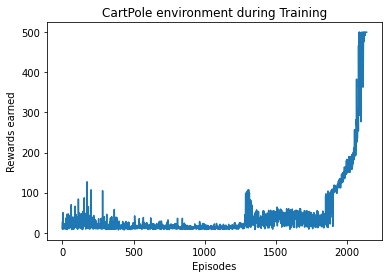

In [4]:
# Define the environment
env = gym.make('CartPole-v1')

# We fill the state and the actions space size
state_size = 4
action_size = 2

# Number of episodes to run
n_episodes = 4000

# Max iterations per epiode
max_iteration_ep = 500

# We define our agent
env_agent = DQNAgent(state_size, action_size)
total_steps = 0
batch_size = 256
total_rewards_earned = []
expo_values = []
rewards_avg = []

# We iterate over episodes
for e in range(n_episodes):
    total_reward_DQN = 0

    current_state,_ = env.reset()
    current_state = np.array([current_state])

    for step in range(max_iteration_ep):

        # Make the agent to compute the action to pass to DQN Neural Network
        action = env_agent.compute_action(current_state,train_cond=True)
        # Get the next state based on action from the defined environment
        next_state, reward, terminated,_,_= env.step(action)
        next_state = np.array([next_state])

        # Storing each experience in the replay buffer with the necessary parameters passed to it
        env_agent.store_episode_values(current_state, action, reward, next_state, done=terminated)

        # Check if the episode is terminated
        if terminated:
            expo_values.append(env_agent.update_explor_probab())
            break
        else:
            current_state = next_state
            total_reward_DQN = total_reward_DQN + reward
            if step%10==0:
                env_agent.train()
                env_agent.soft_update()

    print(f"Episode {e + 1}, Total Reward: {total_reward_DQN}")
    total_rewards_earned.append(total_reward_DQN)
    if sum(rewards_avg)/40 >=470:
        break
    else:
        if len(rewards_avg)>40:
            rewards_avg.pop(0)
        rewards_avg.append(total_reward_DQN)

    if e%3==0:
        env_agent.weight_update()
    
    if total_reward_DQN>=470:
        torch.save(env_agent.send_params(),'CartP-Final.pth')

plt.plot(total_rewards_earned)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('CartPole environment during Training')


Text(0.5, 1.0, 'CartPole environment-Epsilon Decay')

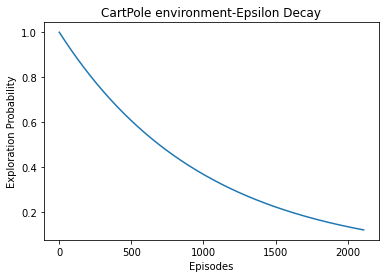

In [5]:
plt.plot(expo_values)
plt.xlabel('Episodes')
plt.ylabel('Exploration Probability')
plt.title('CartPole environment-Epsilon Decay')

In [6]:
#load the weights from file
agent = DQNAgent(state_size=4,action_size=2)
agent.Policy_model.load_state_dict(torch.load('CartP-Final.pth'))
env = gym.make('CartPole-v1')
total_rewards_test = []

for i in range(10):
    state,_ = env.reset()
    total_rewards = 0
    for j in range(500):
        action = agent.compute_action(state,train_cond=False)
        state,reward,done,_,_ = env.step(action)
        if done:
            break
        total_rewards = total_rewards + reward

    total_rewards_test.append(total_rewards)

Text(0.5, 1.0, 'CartPole environment during testing')

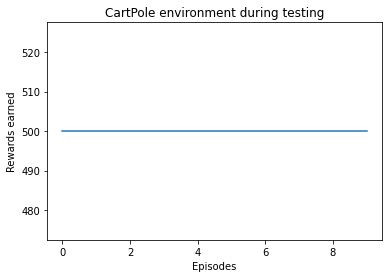

In [7]:
plt.plot(total_rewards_test)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('CartPole environment during testing')

### Acrobat

In [101]:
class DQN_NN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN_NN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_size,100),
            nn.ReLU(),  
            nn.Linear(100,32),
            nn.ReLU(),  
            nn.Linear(32, action_size)
        )
        self.initialize_weights()  
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  
        
    def forward(self, x):
        x = self.layers(x)
        return x


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.num_actions = action_size
        self.lr = 1e-3
        self.gamma = 0.99
        self.exploration_proba = 1
        self.exploration_proba_decay = 0.01
        self.batch_size = 64

        self.rep_buffer = []
        self.maxcap_rep_buffer = 10000

        self.Policy_model = DQN_NN(state_size, action_size)
        self.target_model = DQN_NN(state_size, action_size)
        self.optimizer = optim.Adam(self.Policy_model.parameters(), lr=self.lr,amsgrad=True)
        self.criterion = nn.MSELoss()

    def compute_action(self, current_state,train_cond):
        if train_cond:
            if random.random() < self.exploration_proba:
                return random.randrange(self.num_actions)
            current_state = torch.FloatTensor(current_state)
            self.Policy_model.eval()
            q_values = self.Policy_model(current_state)
            return torch.argmax(q_values).item()
        else:
            current_state = torch.FloatTensor(current_state)
            self.Policy_model.eval()
            q_values = self.Policy_model(current_state)
            return torch.argmax(q_values).item()
            
       
    def update_explor_probab(self):
        self.exploration_proba *= np.exp(-self.exploration_proba_decay)
        return(self.exploration_proba)

    def store_episode_values(self, current_state, action, reward, next_state, done):
        if len(self.rep_buffer) > self.maxcap_rep_buffer:
            self.rep_buffer.pop(0)
            self.rep_buffer.append((current_state, action, reward, next_state, done))
        else:
            self.rep_buffer.append((current_state, action, reward, next_state, done))

    def train(self):
        if len(self.rep_buffer) < self.batch_size:
            return
        batch_sample = np.random.choice(len(self.rep_buffer), self.batch_size, replace=False)
        # self.Policy_model.train()

        for idx in batch_sample:
            current_state, action, reward, next_state, done = self.rep_buffer[idx]
            current_state = torch.FloatTensor(current_state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            reward = torch.tensor(reward).unsqueeze(0)
            action = torch.tensor(action).unsqueeze(0)
            done = torch.tensor(done).unsqueeze(0)

            if done:
                target = reward
            else:
                next_q = self.target_model(next_state).squeeze()
                target = reward + (self.gamma * torch.max(next_q))
            
            self.Policy_model.eval()
            predicted_target = self.Policy_model(current_state).squeeze().gather(0,action)

            loss = self.criterion(predicted_target.float(),target.float()).requires_grad_(True)
            self.optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(self.Policy_model.parameters(),max_norm=1.0)
            self.optimizer.step()

    def weight_update(self):
        self.target_model.load_state_dict(self.Policy_model.state_dict())

    def soft_update(self):
        TAU = 0.0015
        target_net_state_dict = self.target_model.state_dict()
        policy_net_state_dict = self.Policy_model.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

    def send_params(self):
        return self.Policy_model.state_dict()


Episode 1, Total Reward: -500.0
Episode 2, Total Reward: -500.0
Episode 3, Total Reward: -500.0
Episode 4, Total Reward: -500.0
Episode 5, Total Reward: -500.0
Episode 6, Total Reward: -384.0
Episode 7, Total Reward: -500.0
Episode 8, Total Reward: -500.0
Episode 9, Total Reward: -500.0
Episode 10, Total Reward: -500.0
Episode 11, Total Reward: -500.0
Episode 12, Total Reward: -275.0
Episode 13, Total Reward: -500.0
Episode 14, Total Reward: -374.0
Episode 15, Total Reward: -500.0
Episode 16, Total Reward: -500.0
Episode 17, Total Reward: -500.0
Episode 18, Total Reward: -500.0
Episode 19, Total Reward: -500.0
Episode 20, Total Reward: -500.0
Episode 21, Total Reward: -500.0
Episode 22, Total Reward: -500.0
Episode 23, Total Reward: -500.0
Episode 24, Total Reward: -500.0
Episode 25, Total Reward: -500.0
Episode 26, Total Reward: -500.0
Episode 27, Total Reward: -500.0
Episode 28, Total Reward: -500.0
Episode 29, Total Reward: -500.0
Episode 30, Total Reward: -500.0
Episode 31, Total R

Text(0.5, 1.0, 'Acrobat during Training')

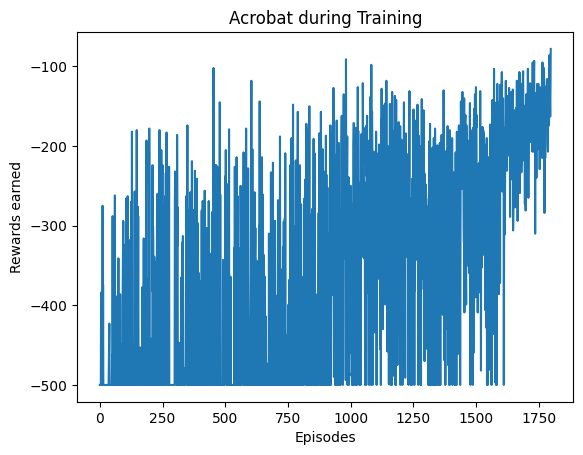

In [104]:
# Define the environment
env = gym.make('Acrobot-v1')

# We fill the state and the actions space size
state_size = env.observation_space.shape[0]
action_size = 3

# Number of episodes to run
n_episodes = 10000

# We define our agent
env_agent = DQNAgent(state_size,action_size)
total_steps = 0
batch_size = 64
total_rewards_earned = []
expo_values = []
rewards_avg = []
prev_reward = 0

# We iterate over episodes
for e in range(n_episodes):
    
    total_reward_DQN = 0
    current_state,_ = env.reset()
    done = False
    steps = 0

    while not done:

        action = env_agent.compute_action(current_state,train_cond=True)
        next_state, reward,done,truncated, info  = env.step(action)
        env_agent.store_episode_values(current_state, action, reward, next_state, done)
        total_reward_DQN = total_reward_DQN + reward

        if done or truncated:
          expo_values.append(env_agent.update_explor_probab())
          # env_agent.train()
          # env_agent.weight_update()
          break
        else:
          if steps%5==0:
            env_agent.train()
            env_agent.soft_update()
          current_state = next_state
          
        steps+=1
        
    print(f"Episode {e + 1}, Total Reward: {total_reward_DQN}")
    total_rewards_earned.append(total_reward_DQN)

    if e%2 == 0:
       env_agent.weight_update()

    if len(rewards_avg)>10:
        rewards_avg.pop(0)
    rewards_avg.append(total_reward_DQN)
    if np.mean(rewards_avg)>=float(-130):
      torch.save(env_agent.send_params(),'Acrobat.pth')
      break
    
    if total_reward_DQN >=-130:
        if total_reward_DQN >=prev_reward:
            torch.save(env_agent.send_params(),'Acrobat.pth')
            prev_reward = total_reward_DQN

plt.plot(total_rewards_earned)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Acrobat during Training')


Text(0.5, 1.0, 'Acrobat environment-Epsilon Decay')

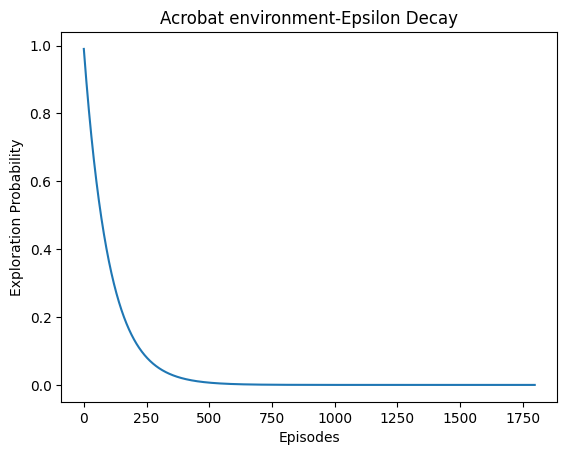

In [106]:
plt.plot(expo_values)
plt.xlabel('Episodes')
plt.ylabel('Exploration Probability')
plt.title('Acrobat environment-Epsilon Decay')

In [109]:
#load the weights from file
env = gym.make('Acrobot-v1')
agent = DQNAgent(state_size=env.observation_space.shape[0],action_size=3)
agent.Policy_model.load_state_dict(torch.load('Acrobat.pth'))
total_rewards_test = []

for i in range(10):
    state,_ = env.reset()
    total_rewards = 0
    for j in range(100):
        action = agent.compute_action(state,train_cond=False)
        state, reward, terminated,truncated, info  = env.step(action)
        if terminated:
            break
        total_rewards = total_rewards + reward

    total_rewards_test.append(total_rewards)

Text(0.5, 1.0, 'Acrobat environment during testing')

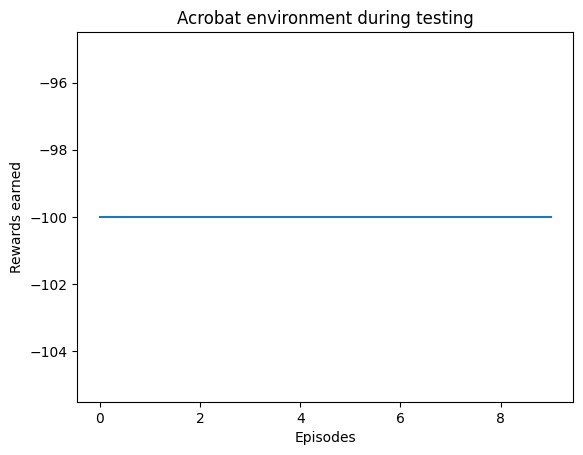

In [110]:
plt.plot(total_rewards_test)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Acrobat environment during testing')

### Grid World environment

In [2]:
class GridEnv_Deterministic(gym.Env):

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None):
        

        self.observation_space = spaces.Discrete(25)

        # To demonstrate 4 actions : "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)    

        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]
        self.state = np.zeros((5,5))
        self.state[tuple(self.agent_pos)] = 2
        self.state[tuple(self.goal_pos)] = 1.5
        self.environment_width = 6
        self.environment_height = 6
        self.r1_flag = 0
        self.r2_flag = 0
        self.r3_flag = 0
        self.r4_flag = 0
        self.r5_flag = 0
        self.r6_flag = 0
        self.r7_flag = 0
        self.r8_flag = 0
        self.r9_flag = 0

        # self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)

        self.ghost = np.asarray([4, 0])
        self.zombie = np.asarray([4, 2])
        self.grim = np.asarray([1, 3])
        self.torchlight = np.asarray([[2, 2], [2, 0]])
        self.pill = np.asarray([3, 3])
        self.torch = np.asarray([0,2])
        self.cloak = np.asarray([2, 4])

      

    # Reset function
    def reset(self, **kwargs):

      self.state = np.zeros((5,5))
      self.agent_pos = [0, 0]
      self.goal_pos = [4, 4]
      self.r1_flag = 0
      self.r2_flag = 0
      self.r3_flag = 0
      self.r4_flag = 0
      self.r5_flag = 0
      self.r6_flag = 0
      self.r7_flag = 0
      self.r8_flag = 0
      self.r9_flag = 0

      return self.agent_pos
    
    def step(self, action):

      curr_pos = ''

      if action == 0: #right
        curr_pos = 'right'
        self.agent_pos[0] += 1
      if action == 1: #left
        curr_pos = 'left'
        self.agent_pos[0] -= 1 
      if action == 2: #up
        curr_pos = 'up'
        self.agent_pos[1] += 1
      if action == 3: #down
        curr_pos = 'down'
        self.agent_pos[1] -= 1
      

      if self.agent_pos[1]<4 or self.agent_pos[1]>0 or self.agent_pos[0]<4 or self.agent_pos[0]>0:
        if self.agent_pos[0]<0:
          curr_pos = 'right'
          self.agent_pos[0] += 2
        if self.agent_pos[1]<0:
            curr_pos = 'up'
            self.agent_pos[1] += 2
        if self.agent_pos[0]>4:
          curr_pos = 'left'
          self.agent_pos[0] -=2
        if self.agent_pos[1]>4:
          curr_pos = 'down'
          self.agent_pos[1] -=2

        
      self.state = np.zeros((5,5))
      self.state[tuple(self.agent_pos)] = 0.6
      self.state[tuple(self.goal_pos)] = 0.5
      observation = self.state.flatten()

      #Rewards

      reward = 0

      if np.array_equal(self.agent_pos,[0,2]) and self.r1_flag==0:
        reward = 3
        self.r1_flag = 1
      elif np.array_equal(self.agent_pos,[1,1]) and self.r2_flag==0:
        reward = 2
        self.r2_flag = 1
      elif np.array_equal(self.agent_pos,[2,0]) and self.r3_flag==0:
        reward = -1
        self.r3_flag = 1
      elif np.array_equal(self.agent_pos,[1,3]) and self.r4_flag==0:
        reward = -3
        self.r4_flag=1
      elif np.array_equal(self.agent_pos,[2,4]) and self.r6_flag==0:
        reward = 4
        self.r6_flag=1
      elif np.array_equal(self.agent_pos,[3,2]) and self.r7_flag==0:
        reward = 1       
        self.r7_flag=1
      elif np.array_equal(self.agent_pos,[4,0]) and self.r8_flag==0:
        reward = 1
        self.r8_flag=1
      elif np.array_equal(self.agent_pos,[4,3]) and self.r9_flag==0:
        reward = -2
        self.r9_flag=1
      elif np.array_equal(self.agent_pos,self.goal_pos):
        reward = 10

      terminated = True if np.array_equal(self.agent_pos, self.goal_pos) else False
      truncated = True if np.all((np.asarray(self.agent_pos) >=0 ) & (np.asarray(self.agent_pos) <= 4)) else False
      
      info = {}

      if curr_pos =='':
        curr_pos = 'Same state due to truncation of going beyond grid'

      return self.agent_pos, reward, terminated, truncated, info , curr_pos

    # Render function: Visualizes the environment
    def grid_render(self, plot=False):

        fig, ax = plt.subplots(figsize=(7,7))
        ax.set_xlim(0,4)
        ax.set_ylim(0,4)
        def plot_image(plot_pos):

        # Initially setting every object to not be plotted.
            plot_agent,plot_goal,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak = \
                False, False, False, False, False, False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.ghost, plot_pos):
                plot_ghost = True
            if np.array_equal(self.zombie, plot_pos):
                plot_zombie = True
            if np.array_equal(self.grim, plot_pos):
                plot_grim = True
            if np.array_equal(self.pill, plot_pos):
                plot_pill= True
            if any(np.array_equal(self.torchlight[i], plot_pos) for i in range(len(self.torchlight))):
                plot_torchlight = True
            if (np.array_equal(self.torch, plot_pos)):
               plot_torch = True
            if np.array_equal(self.cloak, plot_pos):
                plot_cloak = True
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if np.array_equal(self.goal_pos, plot_pos):
                plot_goal = True

            # Plot for Agent.
            if plot_agent and \
                        all(not item for item in
                            [plot_goal,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                    agent = AnnotationBbox(OffsetImage(plt.imread('./RL images/Start.png'), zoom=0.28),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(agent)

            # Plot for ghost
            elif plot_ghost and \
                    all(not item for item in
                        [plot_goal,plot_agent,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                    ghost = AnnotationBbox(OffsetImage(plt.imread('./RL images/little ghost.png'), zoom=0.28),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(ghost)
            
            # Plot for zombie
            elif plot_zombie and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                zombie = AnnotationBbox(OffsetImage(plt.imread('./RL images/Zombie.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(zombie)

            # Plot for Grim Reaper
            elif plot_grim and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                grim = AnnotationBbox(OffsetImage(plt.imread('./RL images/Grim Reaper.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(grim)
        
            # Plot for Torchlight
            elif plot_torchlight and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_pill,plot_torch,plot_cloak]):
                torchlight = AnnotationBbox(OffsetImage(plt.imread('./RL images/Torch light.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(torchlight)

            # Plot for Pill
            elif plot_pill and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_torch,plot_cloak]):
                pill = AnnotationBbox(OffsetImage(plt.imread('./RL images/Ghost Pill.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pill)

            # Plot for Torch
            elif plot_torch and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_cloak]):
                torch = AnnotationBbox(OffsetImage(plt.imread('./RL images/Torch.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(torch)

            # Plot for Cloak
            elif plot_cloak and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch]):
                cloak = AnnotationBbox(OffsetImage(plt.imread('./RL images/Cloak.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(cloak)

            # Plot for Goal
            elif plot_goal and \
                all(not item for item in
                    [plot_cloak,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch]):
                goal = AnnotationBbox(OffsetImage(plt.imread('./RL images/End.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(goal)


            # Plot for Agent and Ghost.
            elif all(item for item in [plot_agent, plot_ghost]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                ghost_scare = AnnotationBbox(OffsetImage(plt.imread('./RL images/Ghost scare.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(ghost_scare)

            # Plot for Agent and Zombie.
            elif all(item for item in [plot_agent, plot_zombie]) and \
                    all(not item for item in
                        [plot_goal,plot_ghost,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                zombie_scare = AnnotationBbox(OffsetImage(plt.imread('./RL images/Zombie scare.png'), zoom=0.28),
                                            np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(zombie_scare)

            # Plot for Agent and Grim Reaper
            elif all(item for item in [plot_agent, plot_grim]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                grim_scare = AnnotationBbox(OffsetImage(plt.imread('./RL images/Grim scare.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(grim_scare)

                # Plot for Agent and Torchlight
            elif all(item for item in [plot_agent, plot_torchlight]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_grim,plot_pill,plot_torch,plot_cloak]):
                Reward = AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)

            # Plot for Agent and Pill
            elif all(item for item in [plot_agent, plot_pill]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_torch,plot_cloak]):
                Reward= AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)

            # Plot for Agent and Torch
            elif all(item for item in [plot_agent, plot_torch]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_pill,plot_cloak]):
                Reward = AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)


            # Plot for Agent and Cloak
            elif all(item for item in [plot_agent, plot_cloak]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_pill,plot_torch]):
                Reward = AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)

            # Plot for Agent and Goal
            elif all(item for item in [plot_agent, plot_goal]) and \
                    all(not item for item in
                        [plot_cloak,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_pill,plot_torch]):
                end_point = AnnotationBbox(OffsetImage(plt.imread('./RL images/End point.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(end_point)

            

        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3, 4,5])
        plt.yticks([0, 1, 2, 3, 4,5])
        plt.grid()
        plt.title('Deterministic environment')

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 1.5
            height = 1.5
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image
      

In [3]:
class DQN_NN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN_NN,self).__init__()
        self.fc1 = nn.Linear(state_size,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,action_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.num_actions = action_size
        self.lr = 1e-3
        self.gamma = 0.99
        self.exploration_proba = 1.0
        self.exploration_proba_decay = 0.001
        self.batch_size = 128

        self.rep_buffer = []
        self.maxcap_rep_buffer = 10000

        self.Policy_model = DQN_NN(state_size, action_size)
        self.target_model = DQN_NN(state_size, action_size)
        self.optimizer = optim.Adam(self.Policy_model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def compute_action(self, current_state,train_cond):
        if train_cond:
            if np.random.rand() < self.exploration_proba:
                return np.random.choice(self.num_actions)
            current_state = torch.FloatTensor(current_state)
            with torch.no_grad():
                self.Policy_model.eval()
                q_values = self.Policy_model(current_state)
            return np.argmax(q_values.cpu().data.numpy())
        else:
            current_state = torch.FloatTensor(current_state).unsqueeze(0)
            with torch.no_grad():
                self.Policy_model.eval()
                q_values = self.Policy_model(current_state)
            return np.argmax(q_values.cpu().data.numpy())
            
       
    def update_explor_probab(self):
        self.exploration_proba *= np.exp(-self.exploration_proba_decay)
        return(self.exploration_proba)

    def store_episode_values(self, current_state, action, reward, next_state, done):
        if len(self.rep_buffer) > self.maxcap_rep_buffer:
            self.rep_buffer.pop(0)
            self.rep_buffer.append((current_state, action, reward, next_state, done))
        else:
            self.rep_buffer.append((current_state, action, reward, next_state, done))

    def train(self):
        if len(self.rep_buffer) < self.batch_size:
            return
        batch_sample = np.random.choice(len(self.rep_buffer), self.batch_size, replace=False)
        self.Policy_model.train()

        total_loss = 0.0

        for idx in batch_sample:
            current_state, action, reward, next_state, done = self.rep_buffer[idx]
            current_state = torch.FloatTensor(current_state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            reward = torch.tensor(reward).unsqueeze(0)
            action = torch.tensor(action).unsqueeze(0)
            done = torch.tensor(done).unsqueeze(0)

            if done:
                target = reward
            else:
                next_q = torch.tensor(self.target_model(next_state).squeeze())
                target = reward + self.gamma * torch.max(next_q)
            
            with torch.no_grad():
                predicted_target = self.Policy_model(current_state).squeeze().gather(0,action)

            loss = self.criterion(predicted_target,target)

            self.optimizer.zero_grad()
            loss = torch.tensor(loss.detach().numpy(), requires_grad=True)
            loss.backward()
            self.optimizer.step()

    def weight_update(self):
        self.target_model.load_state_dict(self.Policy_model.state_dict())

    def soft_update(self):
        TAU = 2e-4
        target_net_state_dict = self.target_model.state_dict()
        policy_net_state_dict = self.Policy_model.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

    def send_params(self):
        return self.Policy_model.state_dict()


In [4]:
# Define the environment
env = GridEnv_Deterministic()

# We fill the state and the actions space size
state_size = 2
action_size = 4

# Number of episodes to run
n_episodes = 5000

# We define our agent
env_agent = DQNAgent(state_size,action_size)
total_steps = 0
batch_size = 128
total_rewards_earned = []
expo_values = []
rewards_avg = []
prev_reward = 0

# We iterate over episodes
for e in range(n_episodes):
    total_reward_DQN = 0

    current_state = env.reset()
    current_state = np.array([current_state])
    terminated = False
    step=0

    while not terminated:

        # Make the agent to compute the action to pass to DQN Neural Network
        action = env_agent.compute_action(current_state,train_cond=True)
        # Get the next state based on action from the defined environment
        next_state, reward, terminated,truncated, info,_  = env.step(action)
        next_state = np.array([next_state])

        # Storing each experience in the replay buffer with the necessary parameters passed to it
        env_agent.store_episode_values(current_state, action, reward, next_state, done=terminated)

        # Check if the episode is terminated
        if terminated:
            total_reward_DQN = total_reward_DQN + reward
            expo_values.append(env_agent.update_explor_probab())
            break
        else:
            current_state = next_state
            total_reward_DQN = total_reward_DQN + reward
            if step%4==0:
                env_agent.train()

    print(f"Episode {e + 1}, Total Reward: {total_reward_DQN}")
    total_rewards_earned.append(total_reward_DQN)
    if e%2==0:
        env_agent.weight_update()
        
    if expo_values[-1]<=0.01:
        
        if total_reward_DQN >=15:
            if total_reward_DQN >=prev_reward:
                torch.save(env_agent.send_params(),'Env-DQN.pth')
                prev_reward = total_reward_DQN

        if (np.mean(rewards_avg)>=float(14)) and len(rewards_avg)>19:
            torch.save(env_agent.send_params(),'Env-DQN.pth')
            break
        else:
            if len(rewards_avg)>20:
                rewards_avg.pop(0)
            rewards_avg.append(total_reward_DQN)

plt.plot(total_rewards_earned)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Grid World Environment during Training')

Episode 1, Total Reward: 14
Episode 2, Total Reward: 11


/scratch/15439472/ipykernel_1684518/1068385699.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_q = torch.tensor(self.target_model(next_state).squeeze())


Episode 3, Total Reward: 15
Episode 4, Total Reward: 15
Episode 5, Total Reward: 12
Episode 6, Total Reward: 12
Episode 7, Total Reward: 15
Episode 8, Total Reward: 15
Episode 9, Total Reward: 15
Episode 10, Total Reward: 12
Episode 11, Total Reward: 15
Episode 12, Total Reward: 18
Episode 13, Total Reward: 15
Episode 14, Total Reward: 15
Episode 15, Total Reward: 15
Episode 16, Total Reward: 14
Episode 17, Total Reward: 14
Episode 18, Total Reward: 14
Episode 19, Total Reward: 15
Episode 20, Total Reward: 14
Episode 21, Total Reward: 10
Episode 22, Total Reward: 11
Episode 23, Total Reward: 15
Episode 24, Total Reward: 15
Episode 25, Total Reward: 11
Episode 26, Total Reward: 15
Episode 27, Total Reward: 15
Episode 28, Total Reward: 15
Episode 29, Total Reward: 13
Episode 30, Total Reward: 17
Episode 31, Total Reward: 15
Episode 32, Total Reward: 13
Episode 33, Total Reward: 12
Episode 34, Total Reward: 17
Episode 35, Total Reward: 15
Episode 36, Total Reward: 14
Episode 37, Total Rew

KeyboardInterrupt: 

Text(0.5, 1.0, 'Grid World Environment during Training')

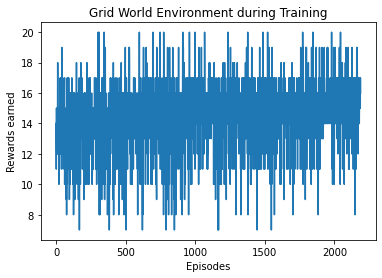

In [5]:
plt.plot(total_rewards_earned)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Grid World Environment during Training')

Text(0.5, 1.0, 'Grid World environment-Epsilon Decay')

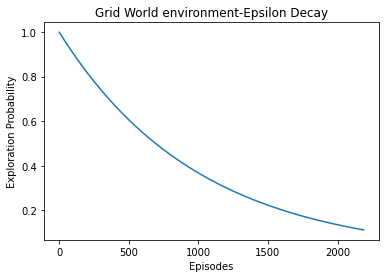

In [6]:
plt.plot(expo_values)
plt.xlabel('Episodes')
plt.ylabel('Exploration Probability')
plt.title('Grid World environment-Epsilon Decay')

In [9]:
#load the weights from file
agent = DQNAgent(state_size=2,action_size=4)
agent.Policy_model.load_state_dict(torch.load('Env-DQN.pth'))
env = GridEnv_Deterministic()
total_rewards_test = []

for i in range(10):
    state = env.reset()
    total_rewards = 0
    for j in range(1000):
        action = agent.compute_action(state,train_cond=False)
        state,reward,done,_,_,_ = env.step(action)
        total_rewards = total_rewards + reward
        if done:
            break

    total_rewards_test.append(total_rewards)

Text(0.5, 1.0, 'Grid World environment during testing')

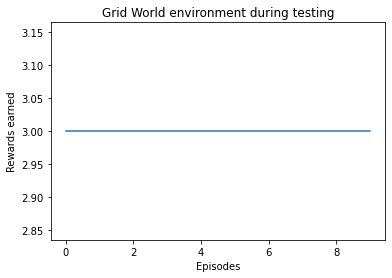

In [10]:
plt.plot(total_rewards_test)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Grid World environment during testing')

## DDQN

### CartPole

In [12]:
class DDQN_NN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDQN_NN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_size,64),
            nn.Softsign(),  
            nn.Linear(64, action_size)
        )
        self.initialize_weights()  
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  
        
    def forward(self, x):
        x = self.layers(x)
        return x


class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.num_actions = action_size
        self.lr = 2e-4
        self.gamma = 0.99
        self.exploration_proba = 1
        self.exploration_proba_decay = 0.01
        self.batch_size = 256

        self.rep_buffer = []
        self.maxcap_rep_buffer = 10000

        self.Policy_model = DDQN_NN(state_size, action_size)
        self.target_model = DDQN_NN(state_size, action_size)
        self.optimizer = optim.Adam(self.Policy_model.parameters(), lr=self.lr,amsgrad=True)
        self.criterion = nn.MSELoss()

    def compute_action(self, current_state,train_cond):
        if train_cond:
            if random.random() < self.exploration_proba:
                return random.randrange(self.num_actions)
            current_state = torch.FloatTensor(current_state)
            self.Policy_model.eval()
            q_values = self.Policy_model(current_state)
            return torch.argmax(q_values).item()
        else:
            current_state = torch.FloatTensor(current_state)
            self.Policy_model.eval()
            q_values = self.Policy_model(current_state)
            return torch.argmax(q_values).item()
            
       
    def update_explor_probab(self):
        self.exploration_proba *= np.exp(-self.exploration_proba_decay)
        return(self.exploration_proba)

    def store_episode_values(self, current_state, action, reward, next_state, done):
        if len(self.rep_buffer) > self.maxcap_rep_buffer:
            self.rep_buffer.pop(0)
            self.rep_buffer.append((current_state, action, reward, next_state, done))
        else:
            self.rep_buffer.append((current_state, action, reward, next_state, done))

    def train(self):
        if len(self.rep_buffer) < self.batch_size:
            return
        batch_sample = np.random.choice(len(self.rep_buffer), self.batch_size, replace=False)
        # self.Policy_model.train()

        for idx in batch_sample:
            current_state, action, reward, next_state, done = self.rep_buffer[idx]
            current_state = torch.FloatTensor(current_state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            reward = torch.tensor(reward).unsqueeze(0)
            action = torch.tensor(action).unsqueeze(0)
            done = torch.tensor(done).unsqueeze(0)

            if done:
                target = reward
            else:
                next_q_online = self.Policy_model(next_state)
                next_q_values = self.target_model(next_state).squeeze()
                next_q = next_q_values.gather(0,torch.argmax(next_q_online))
                target = reward + (self.gamma * next_q)

            self.Policy_model.eval()
            predicted_target = self.Policy_model(current_state).squeeze().gather(0, action)

            loss = self.criterion(predicted_target, target)

            self.optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(self.Policy_model.parameters(), max_norm=1.0)
            self.optimizer.step()


    def weight_update(self):
        self.target_model.load_state_dict(self.Policy_model.state_dict())

    def soft_update(self):
        TAU = 0.0015
        target_net_state_dict = self.target_model.state_dict()
        policy_net_state_dict = self.Policy_model.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

    def send_params(self):
        return self.Policy_model.state_dict()


Episode 1, Total Reward: 36.0
Episode 2, Total Reward: 37.0
Episode 3, Total Reward: 14.0
Episode 4, Total Reward: 37.0
Episode 5, Total Reward: 42.0
Episode 6, Total Reward: 21.0
Episode 7, Total Reward: 18.0
Episode 8, Total Reward: 21.0
Episode 9, Total Reward: 25.0
Episode 10, Total Reward: 18.0
Episode 11, Total Reward: 31.0
Episode 12, Total Reward: 31.0
Episode 13, Total Reward: 21.0
Episode 14, Total Reward: 14.0
Episode 15, Total Reward: 12.0
Episode 16, Total Reward: 20.0
Episode 17, Total Reward: 50.0
Episode 18, Total Reward: 18.0
Episode 19, Total Reward: 69.0
Episode 20, Total Reward: 12.0
Episode 21, Total Reward: 18.0
Episode 22, Total Reward: 16.0
Episode 23, Total Reward: 19.0
Episode 24, Total Reward: 55.0
Episode 25, Total Reward: 20.0
Episode 26, Total Reward: 36.0
Episode 27, Total Reward: 19.0
Episode 28, Total Reward: 13.0
Episode 29, Total Reward: 43.0
Episode 30, Total Reward: 35.0
Episode 31, Total Reward: 18.0
Episode 32, Total Reward: 35.0
Episode 33, Total

Text(0.5, 1.0, 'CartPole environment during Training')

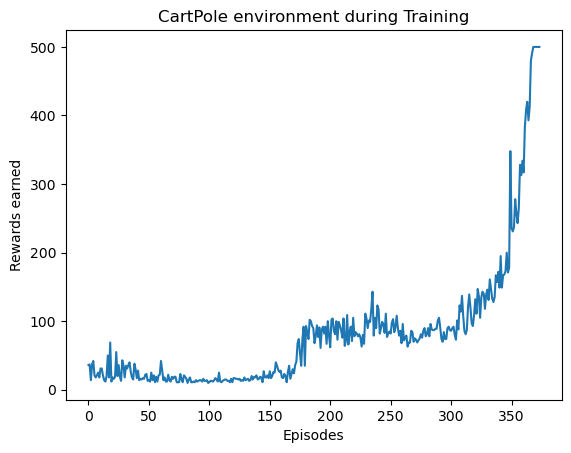

In [13]:
# Define the environment
env = gym.make('CartPole-v1')

# We fill the state and the actions space size
state_size = 4
action_size = 2

# Number of episodes to run
n_episodes = 10000

env_agent = DDQNAgent(state_size, action_size)
total_steps = 0
batch_size = 256
total_rewards_earned = []
expo_values = []
rewards_avg = []
prev_reward = 0

for e in range(n_episodes):
   
    total_reward_DDQN = 0
    current_state,_ = env.reset()
    current_state = np.array([current_state])
    terminated = False
    step = 0

    while not terminated:

        action = env_agent.compute_action(current_state,train_cond=True)
        next_state, reward, terminated,truncated,_= env.step(action)
        next_state = np.array([next_state])
        total_reward_DDQN = total_reward_DDQN + reward
        env_agent.store_episode_values(current_state, action, reward, next_state, done=terminated)
        if terminated or truncated:
            expo_values.append(env_agent.update_explor_probab())
            break
        else:
            if step%10==0:
                env_agent.train()
                env_agent.soft_update()
            current_state = next_state
        step +=1

    if e%2 == 0:
        env_agent.weight_update()

    print(f"Episode {e + 1}, Total Reward: {total_reward_DDQN}")
    total_rewards_earned.append(total_reward_DDQN)
    if len(rewards_avg)>10:
        rewards_avg.pop(0)
    rewards_avg.append(total_reward_DDQN)
    if np.mean(rewards_avg)>=470:
      torch.save(env_agent.send_params(),'CartP-DDQN.pth')
      break
    
    if total_reward_DDQN >=470:
        if total_reward_DDQN >=prev_reward:
            torch.save(env_agent.send_params(),'CartP-DDQN.pth')
            prev_reward = total_reward_DDQN

plt.plot(total_rewards_earned)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('CartPole environment during Training')


Text(0.5, 1.0, 'CartPole environment-Epsilon Decay')

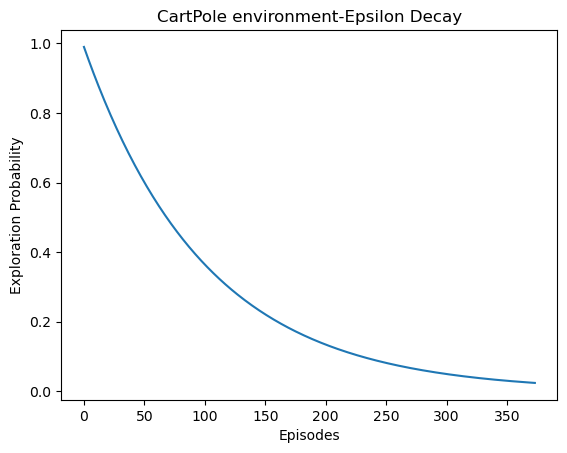

In [14]:
plt.plot(expo_values)
plt.xlabel('Episodes')
plt.ylabel('Exploration Probability')
plt.title('CartPole environment-Epsilon Decay')

In [15]:
#load the weights from file
agent = DDQNAgent(state_size=4,action_size=2)
agent.Policy_model.load_state_dict(torch.load('CartP-DDQN.pth'))
env = gym.make('CartPole-v1')
total_rewards_test = []

for i in range(10):
    state,_ = env.reset()
    total_rewards = 0
    for j in range(500):
        action = agent.compute_action(state,train_cond=False)
        state,reward,done,_,_ = env.step(action)
        total_rewards = total_rewards + reward
        if done:
            break

    total_rewards_test.append(total_rewards)

Text(0.5, 1.0, 'CartPole environment during testing')

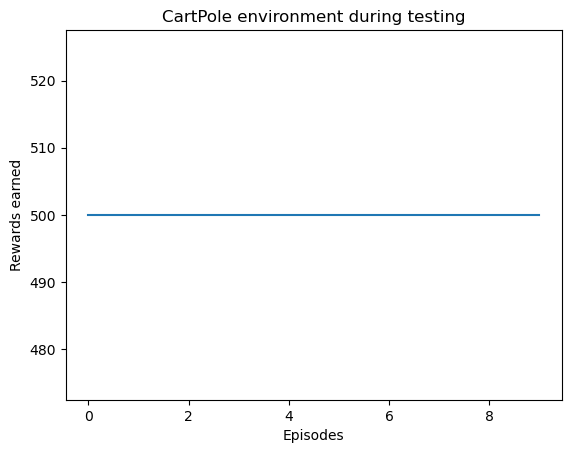

In [16]:
plt.plot(total_rewards_test)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('CartPole environment during testing')

### Acrobat

In [15]:
class DDQN_NN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDQN_NN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_size,128),
            nn.ReLU(),  
            nn.Linear(128,64),
            nn.ReLU(),  
            nn.Linear(64, action_size)
        )
        self.initialize_weights()  
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  
        
    def forward(self, x):
        x = self.layers(x)
        return x


class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.num_actions = action_size
        self.lr = 1e-3
        self.gamma = 0.99
        self.exploration_proba = 1
        self.exploration_proba_decay = 0.01
        self.batch_size = 64

        self.rep_buffer = []
        self.maxcap_rep_buffer = 10000

        self.Policy_model = DDQN_NN(state_size, action_size)
        self.target_model = DDQN_NN(state_size, action_size)
        self.optimizer = optim.Adam(self.Policy_model.parameters(), lr=self.lr,amsgrad=True)
        self.criterion = nn.MSELoss()

    def compute_action(self, current_state,train_cond):
        if train_cond:
            if random.random() < self.exploration_proba:
                return random.randrange(self.num_actions)
            current_state = torch.FloatTensor(current_state)
            self.Policy_model.eval()
            q_values = self.Policy_model(current_state)
            return torch.argmax(q_values).item()
        else:
            current_state = torch.FloatTensor(current_state)
            self.Policy_model.eval()
            q_values = self.Policy_model(current_state)
            return torch.argmax(q_values).item()
            
       
    def update_explor_probab(self):
        self.exploration_proba *= np.exp(-self.exploration_proba_decay)
        return(self.exploration_proba)

    def store_episode_values(self, current_state, action, reward, next_state, done):
        if len(self.rep_buffer) > self.maxcap_rep_buffer:
            self.rep_buffer.pop(0)
            self.rep_buffer.append((current_state, action, reward, next_state, done))
        else:
            self.rep_buffer.append((current_state, action, reward, next_state, done))

    def train(self):
        if len(self.rep_buffer) < self.batch_size:
            return
        batch_sample = np.random.choice(len(self.rep_buffer), self.batch_size, replace=False)
        # self.Policy_model.train()

        for idx in batch_sample:
            current_state, action, reward, next_state, done = self.rep_buffer[idx]
            current_state = torch.FloatTensor(current_state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            reward = torch.tensor(reward).unsqueeze(0)
            action = torch.tensor(action).unsqueeze(0)
            done = torch.tensor(done).unsqueeze(0)

            if done:
                target = reward
            else:
               next_q_online = self.Policy_model(next_state)
               next_q_values = self.target_model(next_state).squeeze()
               next_q = next_q_values.gather(0,torch.argmax(next_q_online))
               target = reward + (self.gamma * next_q)

            self.Policy_model.eval()
            predicted_target = self.Policy_model(current_state).squeeze().gather(0, action)

            loss = self.criterion(predicted_target, target)

            self.optimizer.zero_grad()
            loss = torch.tensor(loss.detach().numpy(), requires_grad=True)
            loss.backward()
            clip_grad_norm_(self.Policy_model.parameters(), max_norm=1.0)
            self.optimizer.step()


    def weight_update(self):
        self.target_model.load_state_dict(self.Policy_model.state_dict())

    def soft_update(self):
        TAU = 0.0015
        target_net_state_dict = self.target_model.state_dict()
        policy_net_state_dict = self.Policy_model.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

    def send_params(self):
        return self.Policy_model.state_dict()


Episode 1, Total Reward: -500.0
Episode 2, Total Reward: -500.0
Episode 3, Total Reward: -500.0
Episode 4, Total Reward: -500.0
Episode 5, Total Reward: -500.0
Episode 6, Total Reward: -500.0
Episode 7, Total Reward: -500.0
Episode 8, Total Reward: -500.0
Episode 9, Total Reward: -500.0
Episode 10, Total Reward: -500.0
Episode 11, Total Reward: -500.0
Episode 12, Total Reward: -500.0
Episode 13, Total Reward: -500.0
Episode 14, Total Reward: -500.0
Episode 15, Total Reward: -500.0
Episode 16, Total Reward: -500.0
Episode 17, Total Reward: -500.0
Episode 18, Total Reward: -500.0
Episode 19, Total Reward: -500.0
Episode 20, Total Reward: -500.0
Episode 21, Total Reward: -500.0
Episode 22, Total Reward: -500.0
Episode 23, Total Reward: -500.0
Episode 24, Total Reward: -500.0
Episode 25, Total Reward: -500.0
Episode 26, Total Reward: -500.0
Episode 27, Total Reward: -500.0
Episode 28, Total Reward: -500.0
Episode 29, Total Reward: -500.0
Episode 30, Total Reward: -500.0
Episode 31, Total R

Text(0.5, 1.0, 'Acrobat during Training')

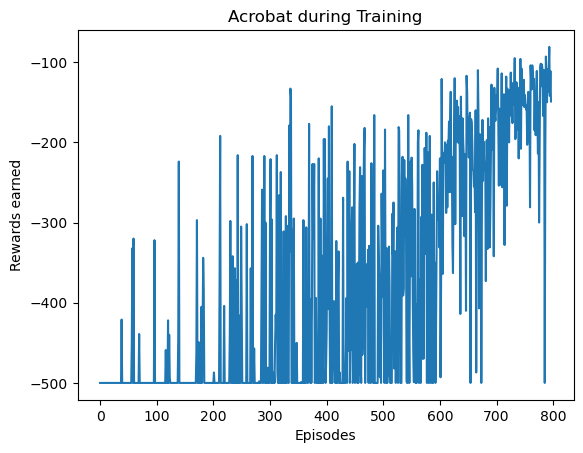

In [16]:
# Define the environment
env = gym.make('Acrobot-v1')

# We fill the state and the actions space size
state_size = env.observation_space.shape[0]
action_size = 3

# Number of episodes to run
n_episodes = 10000

# We define our agent
env_agent = DDQNAgent(state_size,action_size)
total_steps = 0
batch_size = 64
total_rewards_earned = []
expo_values = []
rewards_avg = []
prev_reward = 0

# We iterate over episodes
for e in range(n_episodes):
    
    total_reward_DDQN = 0
    current_state,_ = env.reset()
    done = False
    steps = 0

    while not done:

        action = env_agent.compute_action(current_state,train_cond=True)
        next_state, reward,done,truncated, info  = env.step(action)
        env_agent.store_episode_values(current_state, action, reward, next_state, done)
        total_reward_DDQN = total_reward_DDQN + reward

        if done or truncated:
          expo_values.append(env_agent.update_explor_probab())
          # env_agent.train()
          # env_agent.weight_update()
          break
        else:
          if steps%5==0:
            env_agent.train()
            env_agent.soft_update()
          current_state = next_state
          
        steps+=1
        
    print(f"Episode {e + 1}, Total Reward: {total_reward_DDQN}")
    total_rewards_earned.append(total_reward_DDQN)

    if e%2 == 0:
       env_agent.weight_update()

    if len(rewards_avg)>10:
        rewards_avg.pop(0)
    rewards_avg.append(total_reward_DDQN)
    if np.mean(rewards_avg)>=float(-130):
      torch.save(env_agent.send_params(),'Acrobat_DDQN.pth')
      break
    
    if total_reward_DDQN >=-130:
        if total_reward_DDQN >=prev_reward:
            torch.save(env_agent.send_params(),'Acrobat_DDQN.pth')
            prev_reward = total_reward_DDQN

plt.plot(total_rewards_earned)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Acrobat during Training')


Text(0.5, 1.0, 'Acrobat environment-Epsilon Decay')

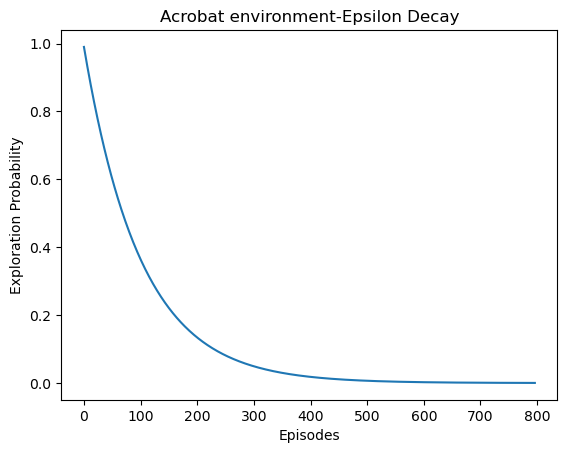

In [17]:
plt.plot(expo_values)
plt.xlabel('Episodes')
plt.ylabel('Exploration Probability')
plt.title('Acrobat environment-Epsilon Decay')

In [19]:
#load the weights from file
env = gym.make('Acrobot-v1')
agent = DDQNAgent(state_size=env.observation_space.shape[0],action_size=3)
agent.Policy_model.load_state_dict(torch.load('Acrobat_DDQN.pth'))
total_rewards_test = []

for i in range(10):
    state,_ = env.reset()
    total_rewards = 0
    for j in range(100):
        action = agent.compute_action(state,train_cond=False)
        state, reward, terminated,truncated, info  = env.step(action)
        if terminated:
            break
        total_rewards = total_rewards + reward

    total_rewards_test.append(total_rewards)

Text(0.5, 1.0, 'Acrobat environment during testing')

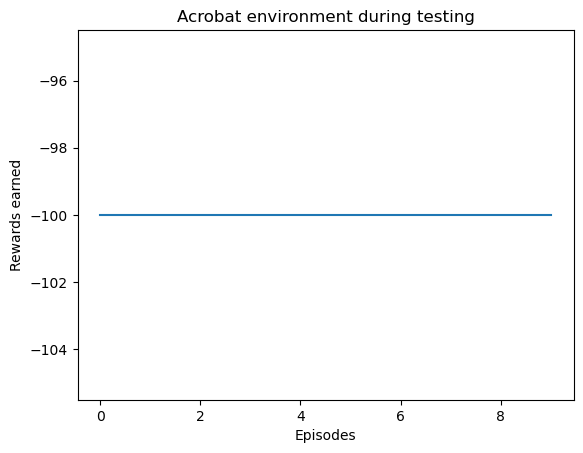

In [20]:
plt.plot(total_rewards_test)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Acrobat environment during testing')

### Grid World Environment

In [65]:
class GridEnv_Deterministic(gym.Env):

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None):
        

        self.observation_space = spaces.Discrete(25)

        # To demonstrate 4 actions : "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)    

        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]
        self.state = np.zeros((5,5))
        self.state[tuple(self.agent_pos)] = 2
        self.state[tuple(self.goal_pos)] = 1.5
        self.environment_width = 6
        self.environment_height = 6
        self.r1_flag = 0
        self.r2_flag = 0
        self.r3_flag = 0
        self.r4_flag = 0
        self.r5_flag = 0
        self.r6_flag = 0
        self.r7_flag = 0
        self.r8_flag = 0
        self.r9_flag = 0

        # self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)

        self.ghost = np.asarray([4, 0])
        self.zombie = np.asarray([4, 2])
        self.grim = np.asarray([1, 3])
        self.torchlight = np.asarray([[2, 2], [2, 0]])
        self.pill = np.asarray([3, 3])
        self.torch = np.asarray([0,2])
        self.cloak = np.asarray([2, 4])

      

    # Reset function
    def reset(self, **kwargs):

      self.state = np.zeros((5,5))
      self.agent_pos = [0, 0]
      self.goal_pos = [4, 4]
      self.r1_flag = 0
      self.r2_flag = 0
      self.r3_flag = 0
      self.r4_flag = 0
      self.r5_flag = 0
      self.r6_flag = 0
      self.r7_flag = 0
      self.r8_flag = 0
      self.r9_flag = 0

      return self.agent_pos
    
    def step(self, action):

      curr_pos = ''

      if action == 0: #right
        curr_pos = 'right'
        self.agent_pos[0] += 1
      if action == 1: #left
        curr_pos = 'left'
        self.agent_pos[0] -= 1 
      if action == 2: #up
        curr_pos = 'up'
        self.agent_pos[1] += 1
      if action == 3: #down
        curr_pos = 'down'
        self.agent_pos[1] -= 1
      

      if self.agent_pos[1]<4 or self.agent_pos[1]>0 or self.agent_pos[0]<4 or self.agent_pos[0]>0:
        if self.agent_pos[0]<0:
          curr_pos = 'right'
          self.agent_pos[0] += 2
        if self.agent_pos[1]<0:
            curr_pos = 'up'
            self.agent_pos[1] += 2
        if self.agent_pos[0]>4:
          curr_pos = 'left'
          self.agent_pos[0] -=2
        if self.agent_pos[1]>4:
          curr_pos = 'down'
          self.agent_pos[1] -=2

        
      self.state = np.zeros((5,5))
      self.state[tuple(self.agent_pos)] = 0.6
      self.state[tuple(self.goal_pos)] = 0.5
      observation = self.state.flatten()

      #Rewards

      reward = 0

      if np.array_equal(self.agent_pos,[0,2]) and self.r1_flag==0:
        reward = 3
        self.r1_flag = 1
      elif np.array_equal(self.agent_pos,[1,1]) and self.r2_flag==0:
        reward = 2
        self.r2_flag = 1
      elif np.array_equal(self.agent_pos,[2,0]) and self.r3_flag==0:
        reward = -1
        self.r3_flag = 1
      elif np.array_equal(self.agent_pos,[1,3]) and self.r4_flag==0:
        reward = -3
        self.r4_flag=1
      elif np.array_equal(self.agent_pos,[2,4]) and self.r6_flag==0:
        reward = 4
        self.r6_flag=1
      elif np.array_equal(self.agent_pos,[3,2]) and self.r7_flag==0:
        reward = 1       
        self.r7_flag=1
      elif np.array_equal(self.agent_pos,[4,0]) and self.r8_flag==0:
        reward = 1
        self.r8_flag=1
      elif np.array_equal(self.agent_pos,[4,3]) and self.r9_flag==0:
        reward = -2
        self.r9_flag=1
      elif np.array_equal(self.agent_pos,self.goal_pos):
        reward = 10

      terminated = True if np.array_equal(self.agent_pos, self.goal_pos) else False
      truncated = True if np.all((np.asarray(self.agent_pos) >=0) & (np.asarray(self.agent_pos) <= 4)) else False
      
      info = {}

      if curr_pos =='':
        curr_pos = 'Same state due to truncation of going beyond grid'

      return self.agent_pos, reward, terminated, info , curr_pos

    # Render function: Visualizes the environment
    def grid_render(self, plot=False):

        fig, ax = plt.subplots(figsize=(7,7))
        ax.set_xlim(0,4)
        ax.set_ylim(0,4)
        def plot_image(plot_pos):

        # Initially setting every object to not be plotted.
            plot_agent,plot_goal,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak = \
                False, False, False, False, False, False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.ghost, plot_pos):
                plot_ghost = True
            if np.array_equal(self.zombie, plot_pos):
                plot_zombie = True
            if np.array_equal(self.grim, plot_pos):
                plot_grim = True
            if np.array_equal(self.pill, plot_pos):
                plot_pill= True
            if any(np.array_equal(self.torchlight[i], plot_pos) for i in range(len(self.torchlight))):
                plot_torchlight = True
            if (np.array_equal(self.torch, plot_pos)):
               plot_torch = True
            if np.array_equal(self.cloak, plot_pos):
                plot_cloak = True
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if np.array_equal(self.goal_pos, plot_pos):
                plot_goal = True

            # Plot for Agent.
            if plot_agent and \
                        all(not item for item in
                            [plot_goal,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                    agent = AnnotationBbox(OffsetImage(plt.imread('./RL images/Start.png'), zoom=0.28),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(agent)

            # Plot for ghost
            elif plot_ghost and \
                    all(not item for item in
                        [plot_goal,plot_agent,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                    ghost = AnnotationBbox(OffsetImage(plt.imread('./RL images/little ghost.png'), zoom=0.28),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(ghost)
            
            # Plot for zombie
            elif plot_zombie and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                zombie = AnnotationBbox(OffsetImage(plt.imread('./RL images/Zombie.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(zombie)

            # Plot for Grim Reaper
            elif plot_grim and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                grim = AnnotationBbox(OffsetImage(plt.imread('./RL images/Grim Reaper.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(grim)
        
            # Plot for Torchlight
            elif plot_torchlight and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_pill,plot_torch,plot_cloak]):
                torchlight = AnnotationBbox(OffsetImage(plt.imread('./RL images/Torch light.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(torchlight)

            # Plot for Pill
            elif plot_pill and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_torch,plot_cloak]):
                pill = AnnotationBbox(OffsetImage(plt.imread('./RL images/Ghost Pill.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pill)

            # Plot for Torch
            elif plot_torch and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_cloak]):
                torch = AnnotationBbox(OffsetImage(plt.imread('./RL images/Torch.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(torch)

            # Plot for Cloak
            elif plot_cloak and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch]):
                cloak = AnnotationBbox(OffsetImage(plt.imread('./RL images/Cloak.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(cloak)

            # Plot for Goal
            elif plot_goal and \
                all(not item for item in
                    [plot_cloak,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch]):
                goal = AnnotationBbox(OffsetImage(plt.imread('./RL images/End.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(goal)


            # Plot for Agent and Ghost.
            elif all(item for item in [plot_agent, plot_ghost]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                ghost_scare = AnnotationBbox(OffsetImage(plt.imread('./RL images/Ghost scare.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(ghost_scare)

            # Plot for Agent and Zombie.
            elif all(item for item in [plot_agent, plot_zombie]) and \
                    all(not item for item in
                        [plot_goal,plot_ghost,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                zombie_scare = AnnotationBbox(OffsetImage(plt.imread('./RL images/Zombie scare.png'), zoom=0.28),
                                            np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(zombie_scare)

            # Plot for Agent and Grim Reaper
            elif all(item for item in [plot_agent, plot_grim]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                grim_scare = AnnotationBbox(OffsetImage(plt.imread('./RL images/Grim scare.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(grim_scare)

                # Plot for Agent and Torchlight
            elif all(item for item in [plot_agent, plot_torchlight]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_grim,plot_pill,plot_torch,plot_cloak]):
                Reward = AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)

            # Plot for Agent and Pill
            elif all(item for item in [plot_agent, plot_pill]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_torch,plot_cloak]):
                Reward= AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)

            # Plot for Agent and Torch
            elif all(item for item in [plot_agent, plot_torch]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_pill,plot_cloak]):
                Reward = AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)


            # Plot for Agent and Cloak
            elif all(item for item in [plot_agent, plot_cloak]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_pill,plot_torch]):
                Reward = AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)

            # Plot for Agent and Goal
            elif all(item for item in [plot_agent, plot_goal]) and \
                    all(not item for item in
                        [plot_cloak,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_pill,plot_torch]):
                end_point = AnnotationBbox(OffsetImage(plt.imread('./RL images/End point.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(end_point)

            

        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3, 4,5])
        plt.yticks([0, 1, 2, 3, 4,5])
        plt.grid()
        plt.title('Deterministic environment')

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 1.5
            height = 1.5
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image
      

In [66]:
class DDQN_NN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDQN_NN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_size,32),
            nn.ReLU(),  
            nn.Linear(32,28),
            nn.ReLU(),  
            nn.Linear(28, action_size)
        )
        self.initialize_weights()  
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  
        
    def forward(self, x):
        x = self.layers(x)
        return x


class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.num_actions = action_size
        self.lr = 0.01
        self.gamma = 0.99
        self.exploration_proba = 1
        self.exploration_proba_decay = 0.01
        self.batch_size = 128

        self.rep_buffer = []
        self.maxcap_rep_buffer = 10000

        self.Policy_model = DDQN_NN(state_size, action_size)
        self.target_model = DDQN_NN(state_size, action_size)
        self.optimizer = optim.Adam(self.Policy_model.parameters(), lr=self.lr,amsgrad=True)
        self.criterion = nn.MSELoss()

    def compute_action(self, current_state,train_cond):
        if train_cond:
            if random.random() < self.exploration_proba:
                return random.randrange(self.num_actions)
            current_state = torch.FloatTensor(current_state)
            self.Policy_model.eval()
            q_values = self.Policy_model(current_state)
            return torch.argmax(q_values).item()
        else:
            current_state = torch.FloatTensor(current_state)
            self.Policy_model.eval()
            q_values = self.Policy_model(current_state)
            return torch.argmax(q_values).item()
            
       
    def update_explor_probab(self):
        self.exploration_proba *= np.exp(-self.exploration_proba_decay)
        return(self.exploration_proba)

    def store_episode_values(self, current_state, action, reward, next_state, done):
        if len(self.rep_buffer) > self.maxcap_rep_buffer:
            self.rep_buffer.pop(0)
            self.rep_buffer.append((current_state, action, reward, next_state, done))
        else:
            self.rep_buffer.append((current_state, action, reward, next_state, done))

    def train(self):
        if len(self.rep_buffer) < self.batch_size:
            return
        batch_sample = np.random.choice(len(self.rep_buffer), self.batch_size, replace=False)
        # self.Policy_model.train()

        for idx in batch_sample:
            current_state, action, reward, next_state, done = self.rep_buffer[idx]
            current_state = torch.FloatTensor(current_state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            reward = torch.tensor(reward).unsqueeze(0)
            action = torch.tensor(action).unsqueeze(0)
            done = torch.tensor(done).unsqueeze(0)

            if done:
                target = reward
            else:
               next_q_online = self.Policy_model(next_state)
               next_q_values = self.target_model(next_state).squeeze()
               next_q = next_q_values.gather(0,torch.argmax(next_q_online))
               target = reward + (self.gamma * next_q)

            self.Policy_model.eval()
            predicted_target = self.Policy_model(current_state).squeeze().gather(0, action)

            loss = self.criterion(predicted_target, target)

            self.optimizer.zero_grad()
            loss = torch.tensor(loss.detach().numpy(), requires_grad=True)
            loss.backward()
            clip_grad_norm_(self.Policy_model.parameters(), max_norm=1.0)
            self.optimizer.step()


    def weight_update(self):
        self.target_model.load_state_dict(self.Policy_model.state_dict())

    def soft_update(self):
        TAU = 0.0015
        target_net_state_dict = self.target_model.state_dict()
        policy_net_state_dict = self.Policy_model.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

    def send_params(self):
        return self.Policy_model.state_dict()


Episode 1, Total Reward: 15
Episode 2, Total Reward: 15
Episode 3, Total Reward: 15
Episode 4, Total Reward: 14
Episode 5, Total Reward: 14
Episode 6, Total Reward: 8
Episode 7, Total Reward: 13
Episode 8, Total Reward: 17
Episode 9, Total Reward: 10
Episode 10, Total Reward: 13
Episode 11, Total Reward: 17
Episode 12, Total Reward: 17
Episode 13, Total Reward: 15
Episode 14, Total Reward: 15
Episode 15, Total Reward: 6
Episode 16, Total Reward: 12
Episode 17, Total Reward: 11
Episode 18, Total Reward: 15
Episode 19, Total Reward: 17
Episode 20, Total Reward: 11
Episode 21, Total Reward: 17
Episode 22, Total Reward: 13
Episode 23, Total Reward: 15
Episode 24, Total Reward: 11
Episode 25, Total Reward: 15
Episode 26, Total Reward: 12
Episode 27, Total Reward: 16
Episode 28, Total Reward: 15
Episode 29, Total Reward: 14
Episode 30, Total Reward: 14
Episode 31, Total Reward: 10
Episode 32, Total Reward: 14
Episode 33, Total Reward: 11
Episode 34, Total Reward: 13
Episode 35, Total Reward:

Text(0.5, 1.0, 'Grid World environment during Training')

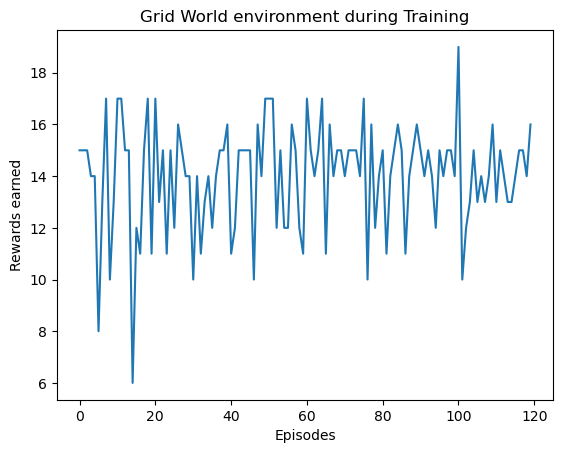

In [69]:
# Define the environment
env = GridEnv_Deterministic()

# We fill the state and the actions space size
state_size = 2
action_size = 4

# Number of episodes to run
n_episodes = 10000

# We define our agent
env_agent = DDQNAgent(state_size,action_size)
total_steps = 0
batch_size = 128
total_rewards_earned = []
expo_values = []
rewards_avg = []
prev_reward = 0

# We iterate over episodes
for e in range(n_episodes):
    
    total_reward_DDQN = 0
    current_state = env.reset()
    done = False
    steps = 0

    while not done:

        action = env_agent.compute_action(current_state,train_cond=True)
        next_state, reward,done,info,_  = env.step(action)
        env_agent.store_episode_values(current_state, action, reward, next_state, done)
        total_reward_DDQN = total_reward_DDQN + reward

        if done:
          expo_values.append(env_agent.update_explor_probab())
          # env_agent.train()
          # env_agent.weight_update()
          break
        else:
          if steps%5==0:
            env_agent.train()
            env_agent.soft_update()
          current_state = next_state
          
        steps+=1
        
    print(f"Episode {e + 1}, Total Reward: {total_reward_DDQN}")
    total_rewards_earned.append(total_reward_DDQN)

    if e%2 == 0:
       env_agent.weight_update()

    if e>=100:
      if len(rewards_avg)>20:
          rewards_avg.pop(0)
      rewards_avg.append(total_reward_DDQN)
      if len(rewards_avg)>19:
        if (np.mean(rewards_avg)>=float(9)):
          torch.save(env_agent.send_params(),'Grid-env_DDQN.pth')
          break
      
      if total_reward_DDQN >=12:
          if total_reward_DDQN >=prev_reward:
              torch.save(env_agent.send_params(),'Grid-env_DDQN.pth')
              prev_reward = total_reward_DDQN

plt.plot(total_rewards_earned)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Grid World environment during Training')


Text(0.5, 1.0, 'Grid World environment-Epsilon Decay')

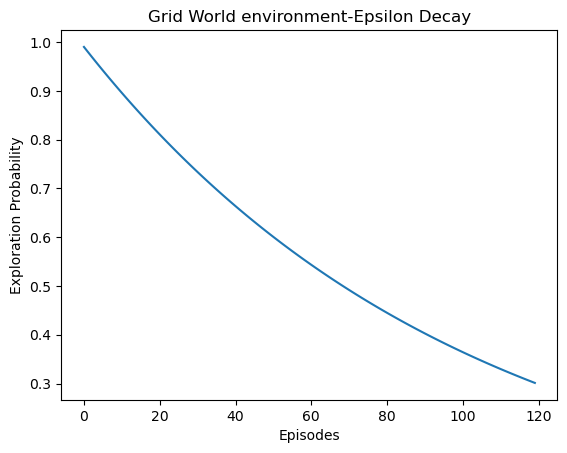

In [70]:
plt.plot(expo_values)
plt.xlabel('Episodes')
plt.ylabel('Exploration Probability')
plt.title('Grid World environment-Epsilon Decay')

In [82]:
#load the weights from file
env = GridEnv_Deterministic()
agent = DDQNAgent(state_size=2,action_size=4)
agent.Policy_model.load_state_dict(torch.load('Grid-env_DDQN.pth'))
total_rewards_test = []

for i in range(7):
    current_state = env.reset()
    total_rewards = 0
    terminated = False
    for j in range(500):
        action = agent.compute_action(current_state,train_cond=False)
        next_state, reward, terminated,info,_  = env.step(action)
        total_rewards = total_rewards + reward
        if terminated:
            break
        else:
            current_state = next_state
            
    total_rewards_test.append(total_rewards)

Text(0.5, 1.0, 'Grid World environment during testing')

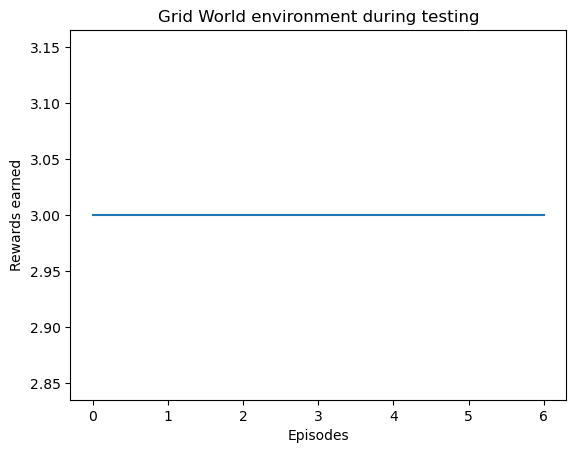

In [83]:
plt.plot(total_rewards_test)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Grid World environment during testing')